In [ ]:
# Import TensorFlow and Keras libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Import data handling and preprocessing libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder

# Import visualization libraries
import matplotlib.pyplot as plt

# Import OS for file path handling
import os

In [ ]:
# Load dataset information
# Use a raw string for the path to avoid SyntaxWarning about invalid escape sequences.
df = pd.read_csv(r"F:\Hand_W\english.csv")

# Encode labels properly
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["label"])  # Convert labels to unique integers

# Save mapping for reference
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

# Add full image path
# The error message "OSError: [Errno 22] Invalid argument: 'F:\\\\Hand_W\\\\PNG/F:\\\\Hand_W\\\\PNG/CAP_A_0.png'"
# indicates that the base path "F:\Hand_W\PNG/" was prepended twice to the image filename.
# This strongly suggests that the 'image' column in 'english.csv' already contains the full path
# (e.g., "F:\Hand_W\PNG/CAP_A_0.png").
# Therefore, the line that attempts to prepend the path again is redundant and causes the error.
# We will remove it, assuming the paths in the CSV are already complete.
# df["image"] = "F:\Hand_W\PNG/" + df["image"] # This line is removed to fix the double path error.

# Load images and labels
img_size = 64
x, y = [], df["label"].values

for img_path in df["image"]:
    # img_path now directly contains the full, correct path from the CSV
    img = load_img(img_path, color_mode="grayscale", target_size=(img_size, img_size))
    img = img_to_array(img) / 255.0  # Normalize
    x.append(img)

x = np.array(x).reshape(-1, img_size, img_size, 1)  # Add channel dimension
y = np.array(y)  # Now, labels are integers

# Get unique class labels
class_names = label_encoder.classes_
print(f'Total classes: {len(class_names)}')
print(f'Classes: {class_names}')


Label Mapping: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6), np.int64(7): np.int64(7), np.int64(8): np.int64(8), np.int64(9): np.int64(9), np.int64(10): np.int64(10), np.int64(11): np.int64(11), np.int64(12): np.int64(12), np.int64(13): np.int64(13), np.int64(14): np.int64(14), np.int64(15): np.int64(15), np.int64(16): np.int64(16), np.int64(17): np.int64(17), np.int64(18): np.int64(18), np.int64(19): np.int64(19), np.int64(20): np.int64(20), np.int64(21): np.int64(21), np.int64(22): np.int64(22), np.int64(23): np.int64(23), np.int64(24): np.int64(24), np.int64(25): np.int64(25), np.int64(26): np.int64(26), np.int64(27): np.int64(27), np.int64(28): np.int64(28), np.int64(29): np.int64(29), np.int64(30): np.int64(30), np.int64(31): np.int64(31), np.int64(32): np.int64(32), np.int64(33): np.int64(33), np.int64(34): np.int64(34), np.int64(35): np.int64(3

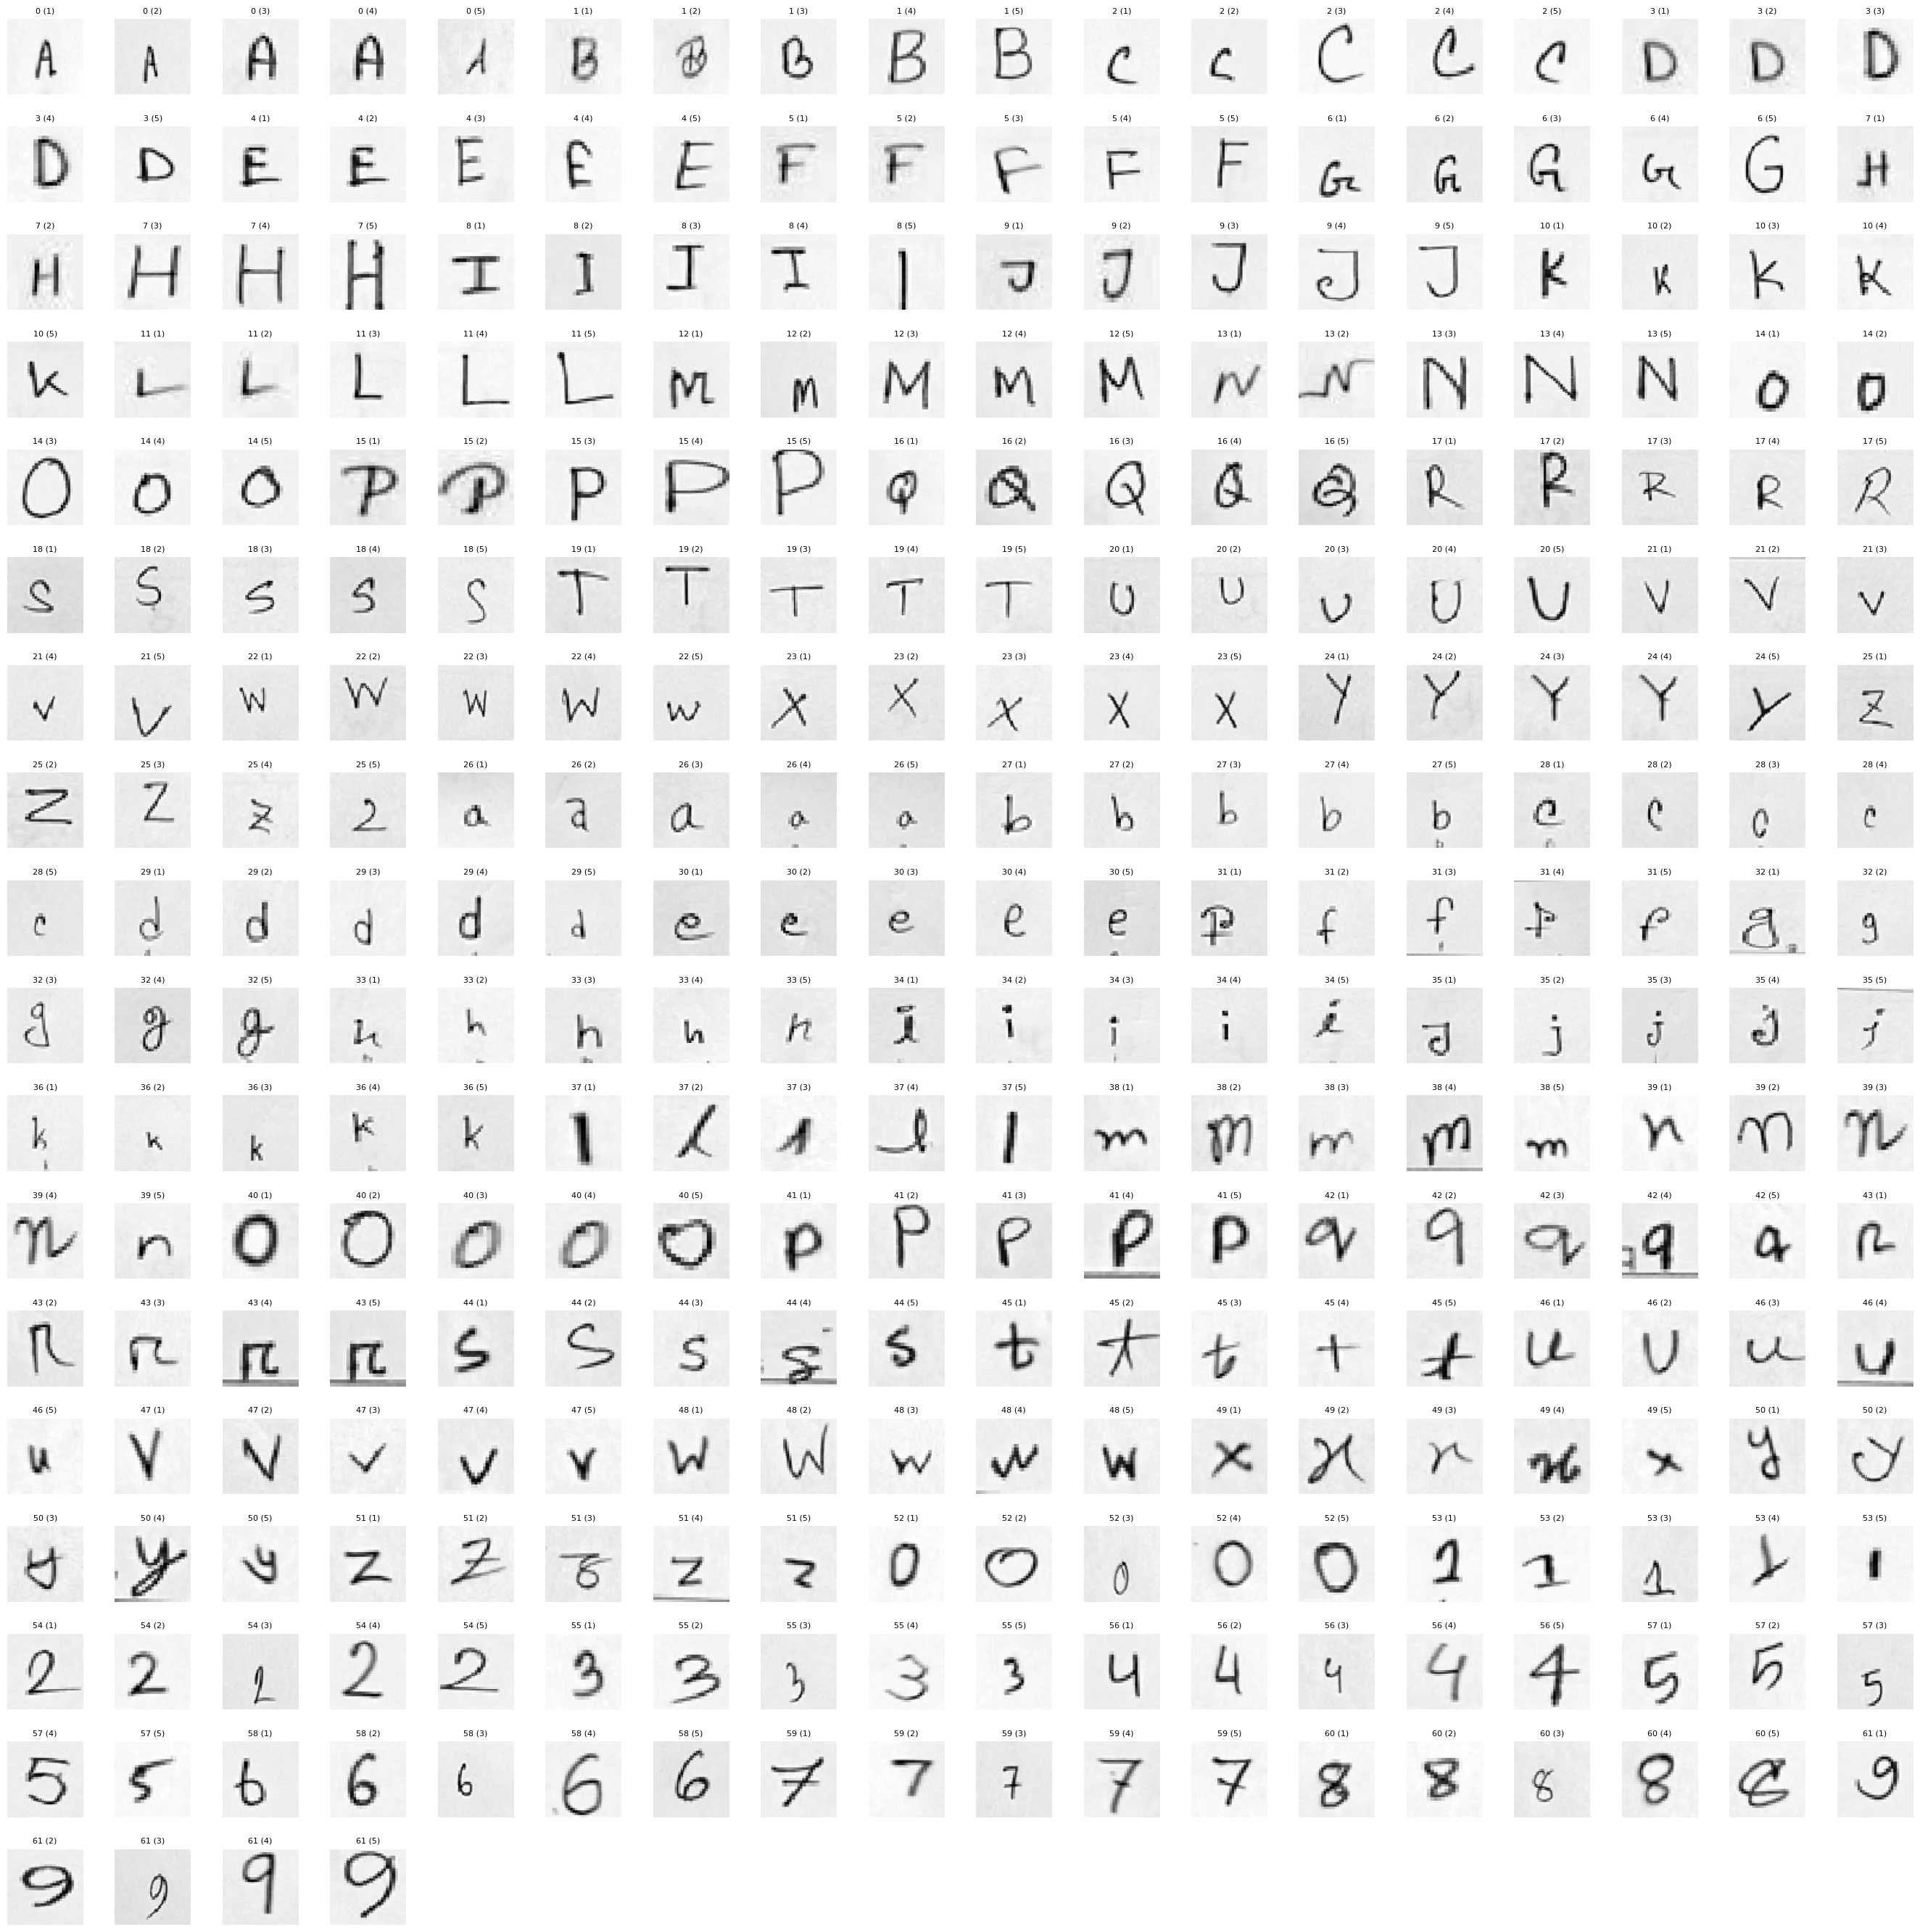

In [ ]:
# Display 5 images per class
num_images_per_class = 5
num_classes = len(class_names)
total_images_to_display = num_classes * num_images_per_class

# Determine grid size for subplots to accommodate all images.
# For 62 classes * 5 images/class = 310 images.
# A square-ish grid is often preferred. sqrt(310) is approximately 17.6.
# So, an 18x18 grid (324 plots) is suitable.
grid_dimension = int(np.ceil(np.sqrt(total_images_to_display)))
rows = grid_dimension
cols = grid_dimension

# Adjust figure size dynamically. A factor of 1.5-2 per subplot dimension is often good.
# This will create a figure large enough to display all images clearly.
plt.figure(figsize=(cols * 1.5, rows * 1.5)) 

# Dictionary to keep track of how many images have been displayed for each class
images_displayed_per_class = {class_label: 0 for class_label in range(num_classes)}
global_plot_index = 0 # Tracks the current subplot position (1-indexed)

for i in range(len(y)):
    current_class_label = y[i]
    
    # Check if we still need to display more images for this class
    if images_displayed_per_class[current_class_label] < num_images_per_class:
        global_plot_index += 1
        plt.subplot(rows, cols, global_plot_index) 
        plt.imshow(x[i].reshape(img_size, img_size), cmap='gray')
        
        # Get the class name using LabelEncoder for display
        class_name = label_encoder.inverse_transform([current_class_label])[0]
        
        # Set title with class name and the count for that specific class
        plt.title(f'{class_name} ({images_displayed_per_class[current_class_label] + 1})', fontsize=8) 
        plt.axis("off") # Hide axes for cleaner display
        
        images_displayed_per_class[current_class_label] += 1
        
    # Break the loop if we have displayed the required number of images for all classes
    if global_plot_index == total_images_to_display:  
        break

plt.tight_layout(pad=2.0) # Adjust subplot parameters for a tight layout
plt.show()

In [ ]:
# Split dataset (80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

# Print dataset shapes before shuffling
print(f"Training set: {x_train.shape}, Labels: {y_train.shape}")
print(f"Testing set: {x_test.shape}, Labels: {y_test.shape}")

# Shuffle the dataset
x, y = shuffle(x, y, random_state=42)

# Split dataset (80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

# Print dataset shapes After Shuffling
print(f"Training set: {x_train.shape}, Labels: {y_train.shape}")
print(f"Testing set: {x_test.shape}, Labels: {y_test.shape}")

Training set: (4960, 64, 64, 1), Labels: (4960,)
Testing set: (1240, 64, 64, 1), Labels: (1240,)
Training set: (4960, 64, 64, 1), Labels: (4960,)
Testing set: (1240, 64, 64, 1), Labels: (1240,)


In [ ]:
# Define Custom CNN Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Define the input layer
inputs = Input(shape=(img_size, img_size, 1))

# Convolutional Layer
x = Conv2D(64, (5, 5), activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# Convolutional Layer 2
x = Conv2D(128, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# Convolutional Layer 3
x = Conv2D(256, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# Flatten the feature maps
x = Flatten()(x)

# Fully Connected Layer with L2 Regularization
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)

# Output Layer
outputs = Dense(len(class_names), activation='softmax')(x)  # 62 classes

# Create the model using the Functional API
model = Model(inputs=inputs, outputs=outputs)

# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0001)  # Smaller learning rate
model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 60, 60, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 60, 60, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 62)             │        31,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,123,390 (19.54 MB)

 Trainable params: 5,122,494 (19.54 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
# Train the model with more epochs and early stopping
history = model.fit(x_train, y_train,
                        epochs=15, 
                        batch_size=32,
                        validation_data=(x_test, y_test),
                        callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]) 

Epoch 1/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.3056 - loss: 3.9019 - val_accuracy: 0.0161 - val_loss: 6.5179
Epoch 2/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.7163 - loss: 2.0432 - val_accuracy: 0.0185 - val_loss: 6.4490
Epoch 3/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.8940 - loss: 1.3723 - val_accuracy: 0.2250 - val_loss: 3.9788
Epoch 4/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - accuracy: 0.9768 - loss: 1.0876 - val_accuracy: 0.6032 - val_loss: 2.3925
Epoch 5/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 0.9976 - loss: 0.9721 - val_accuracy: 0.7242 - val_loss: 1.9246
Epoch 6/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 24s 158ms/step - accuracy: 1.0000 - loss: 0.9212 - val_accuracy: 0.7315 - val_loss: 1.8788
Epoch 7/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 25s 158ms/step - accuracy: 1.0000 - loss: 0.8897 - val_accuracy: 0.7315 - val_loss: 1.8344
Epoch 8/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 15s 96ms/step - accuracy: 1.0000 - loss: 0.8614

In [ ]:
# Evaluate Model on Test Data
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Model - Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.5f}")

Model - Test Loss: 1.5701, Test Accuracy: 0.74113


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

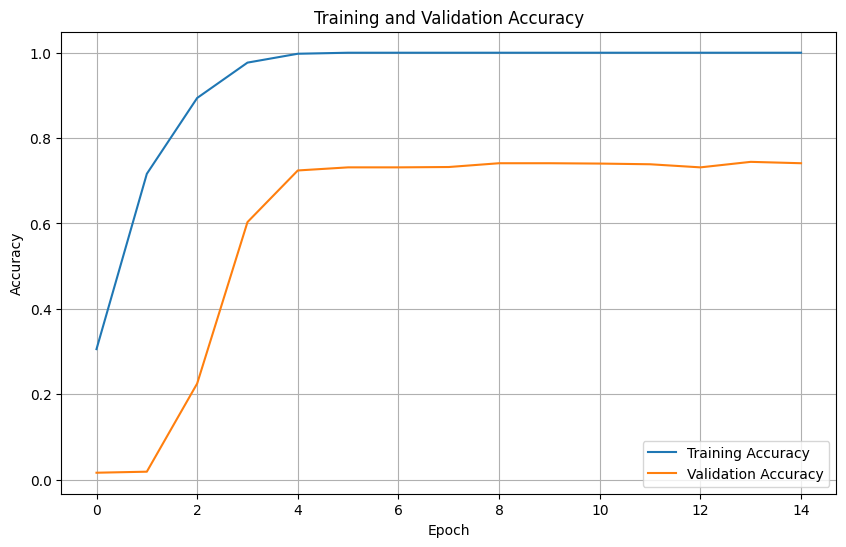

In [ ]:
#Plot Training & Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

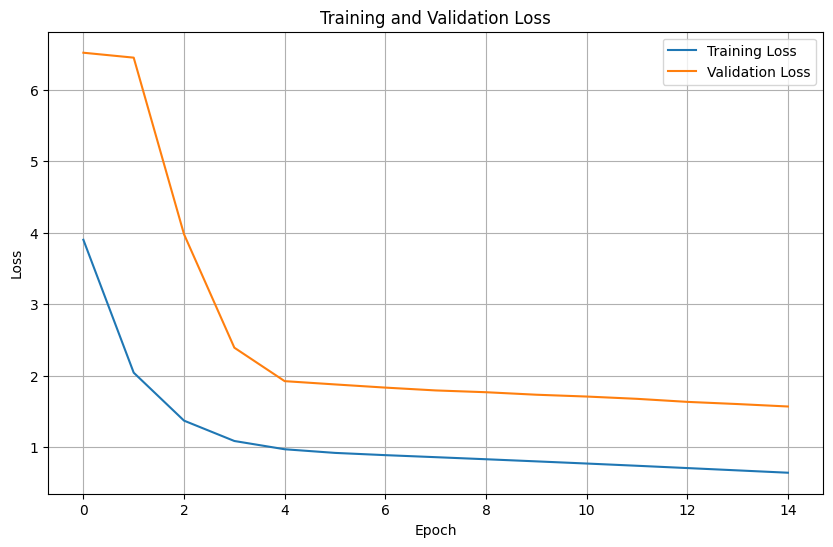

In [ ]:
#Plot Training & Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Get predictions for test set
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [ ]:
# Classification Report
print("\n--- Classification Report ---")
string_class_names = [str(cn) for cn in class_names]

print(classification_report(y_test, y_pred, target_names=string_class_names))


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.79      0.95      0.86        20
           1       0.68      0.75      0.71        20
           2       0.85      0.85      0.85        20
           3       0.93      0.70      0.80        20
           4       0.86      0.90      0.88        20
           5       0.78      0.70      0.74        20
           6       0.95      0.95      0.95        20
           7       0.68      0.95      0.79        20
           8       0.81      0.85      0.83        20
           9       0.88      0.70      0.78        20
          10       0.83      0.75      0.79        20
          11       0.90      0.95      0.93        20
          12       0.88      0.70      0.78        20
          13       0.81      0.65      0.72        20
          14       0.68      0.65      0.67        20
          15       0.75      0.75      0.75        20
          16       0.89      0.80      0.84       

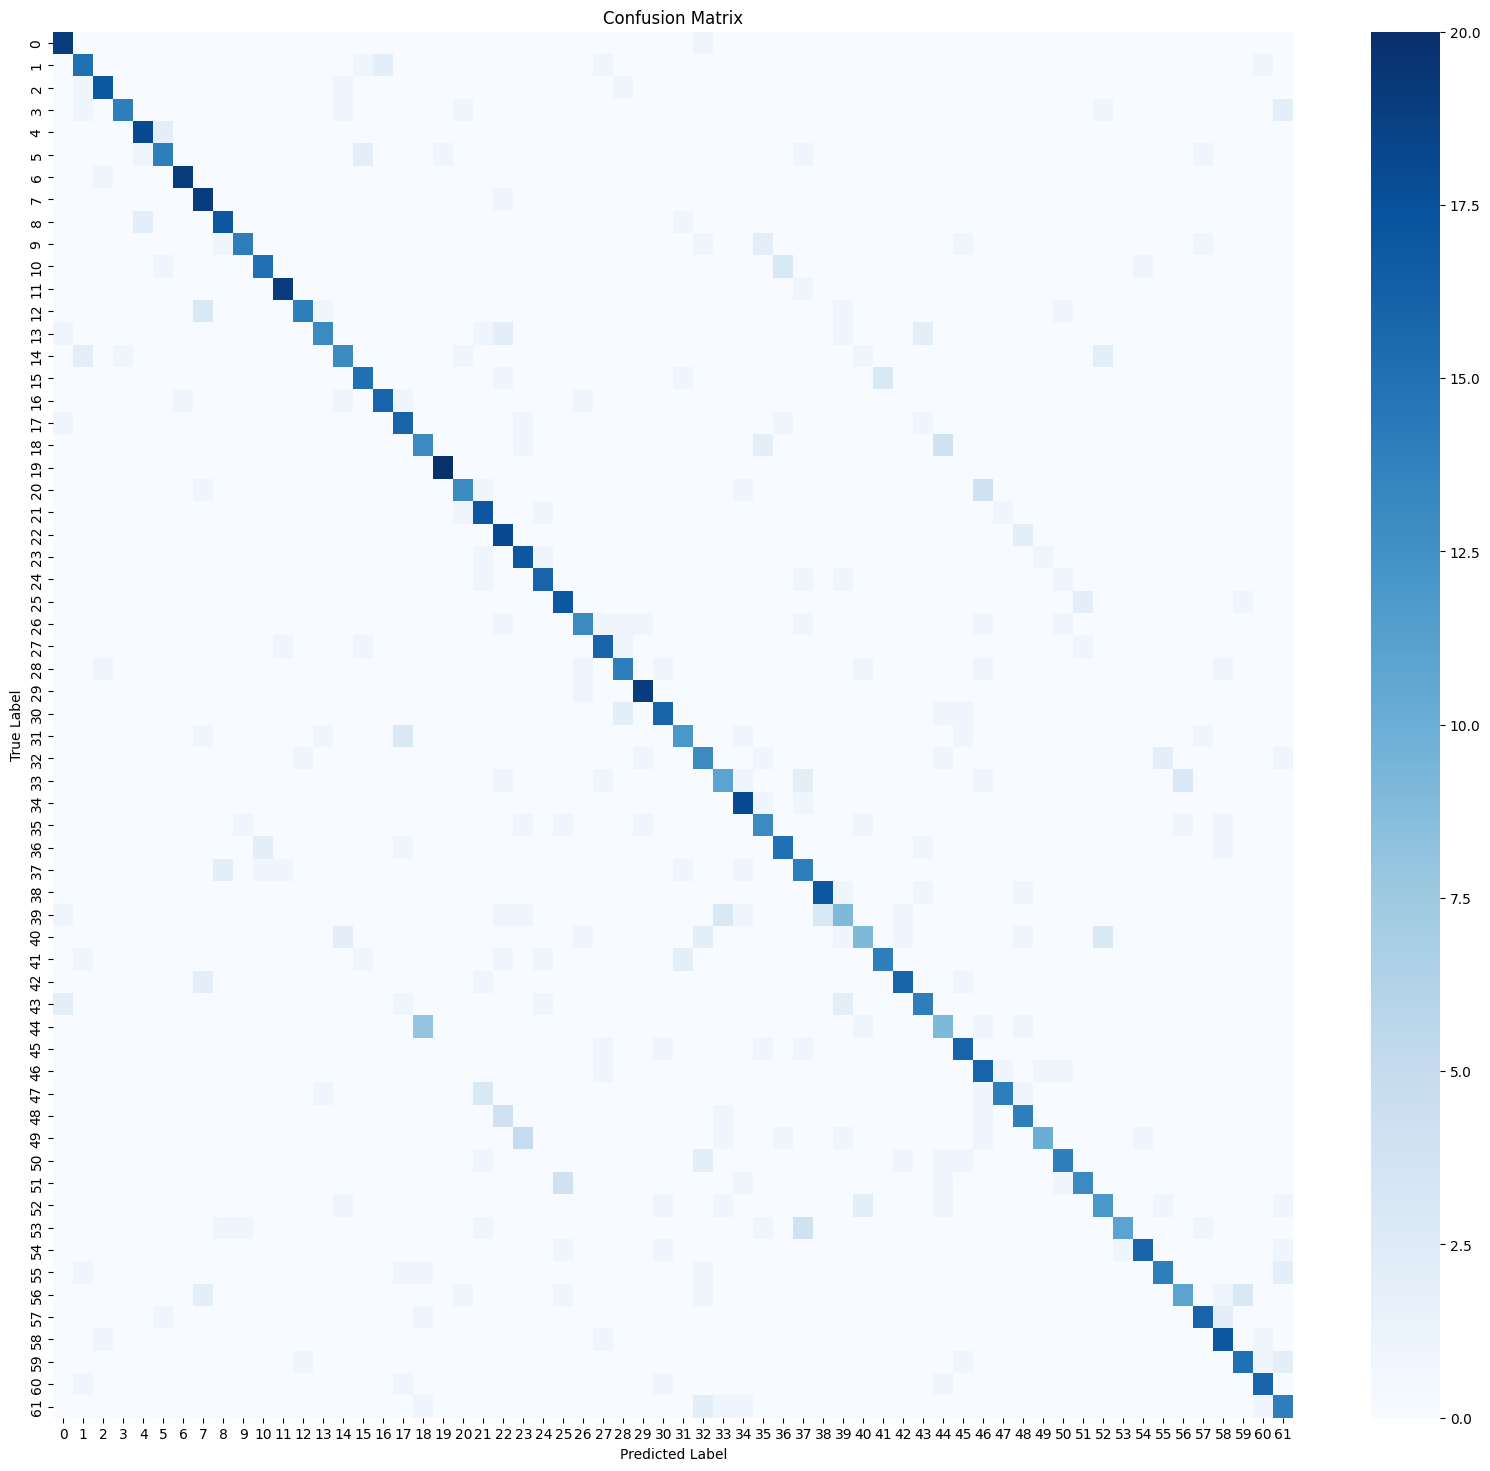

In [ ]:
# Confusion Matrix (Heatmap)
# Note: For 62 classes, this heatmap will be very large and potentially unreadable.
# Consider using a smaller subset of classes or focusing on the classification report for detailed metrics.
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20, 18)) # Make figure very large to accommodate many classes
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

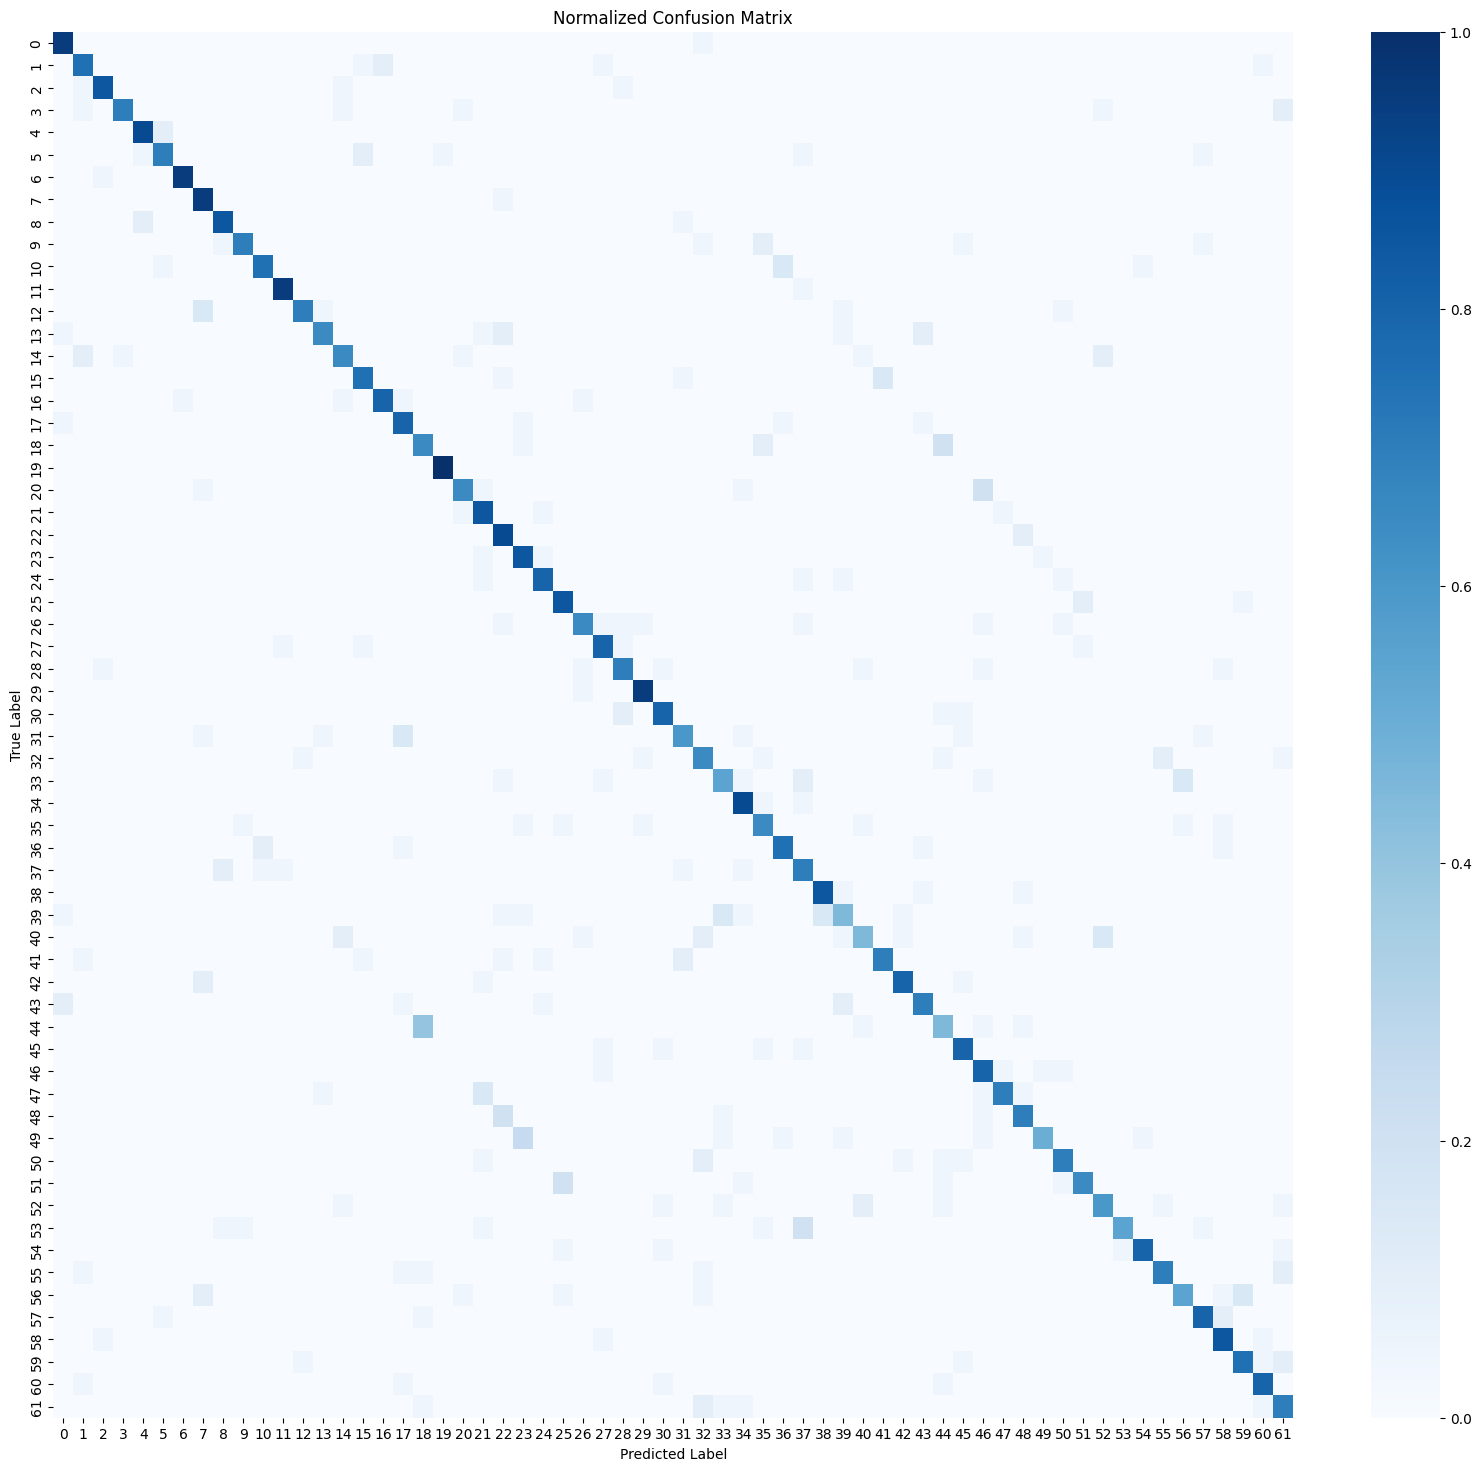

In [ ]:
# Normalized Confusion Matrix (Heatmap)
# Also very large for 62 classes. Shows proportion of true labels predicted as each class.
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(20, 18)) # Make figure very large
sns.heatmap(cm_normalized, annot=False, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


--- Sample Correct Predictions ---


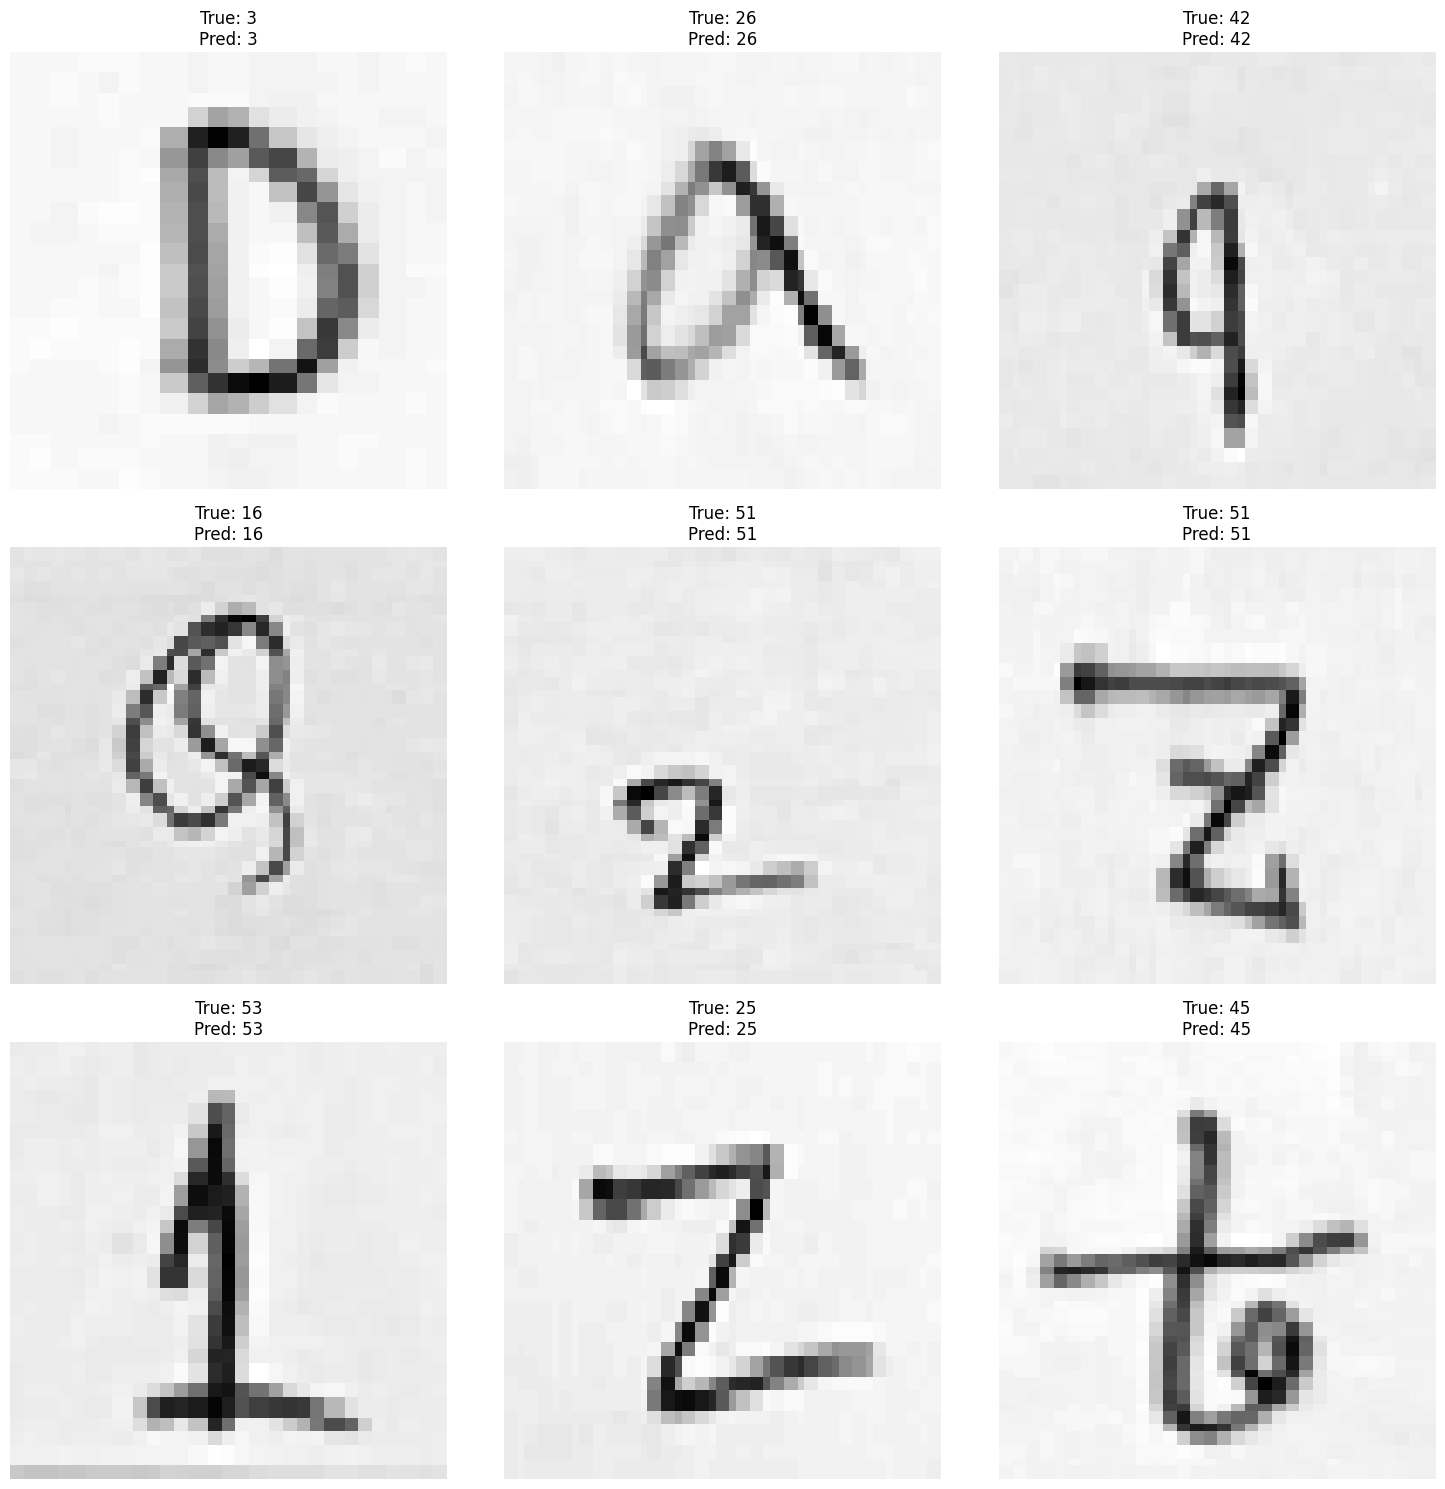

In [ ]:
# Visualize Sample Correct Predictions
print("\n--- Sample Correct Predictions ---")
correct_indices = np.where(y_pred == y_test)[0]
np.random.shuffle(correct_indices)
plt.figure(figsize=(15, 15))
for i, correct in enumerate(correct_indices[:9]): # Display 9 correct predictions
    plt.subplot(3, 3, i + 1)
    # Assuming x_test images are 64x64 grayscale (shape 64,64,1)
    plt.imshow(x_test[correct].reshape(64, 64), cmap='gray')
    plt.title(f"True: {class_names[y_test[correct]]}\nPred: {class_names[y_pred[correct]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


--- Sample Incorrect Predictions ---


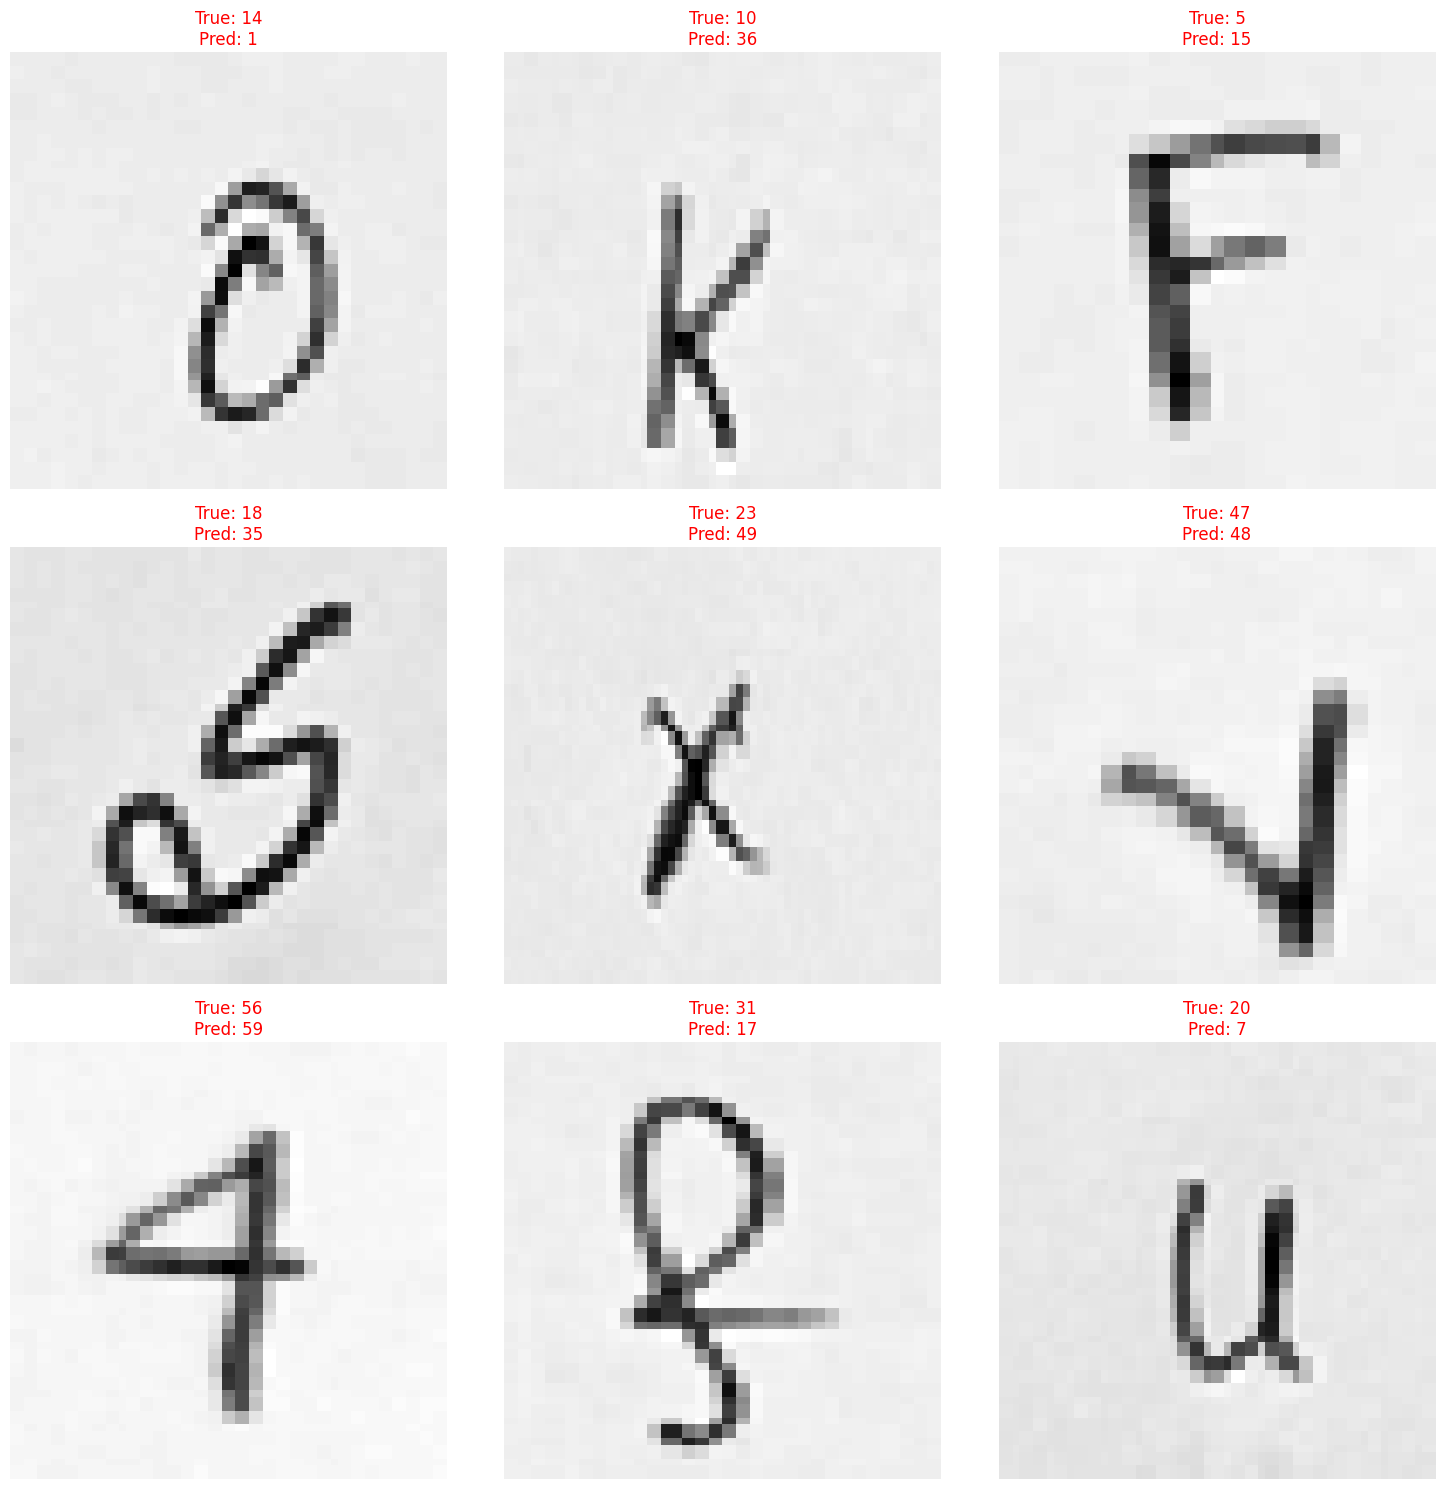

In [ ]:
# Visualize Sample Incorrect Predictions
print("\n--- Sample Incorrect Predictions ---")
incorrect_indices = np.where(y_pred != y_test)[0]
np.random.shuffle(incorrect_indices)
plt.figure(figsize=(15, 15))
for i, incorrect in enumerate(incorrect_indices[:9]): # Display 9 incorrect predictions
    plt.subplot(3, 3, i + 1)
    # Assuming x_test images are 64x64 grayscale (shape 64,64,1)
    plt.imshow(x_test[incorrect].reshape(64, 64), cmap='gray')
    plt.title(f"True: {class_names[y_test[incorrect]]}\nPred: {class_names[y_pred[incorrect]]}", color='red')
    plt.axis('off')
plt.tight_layout()
plt.show()

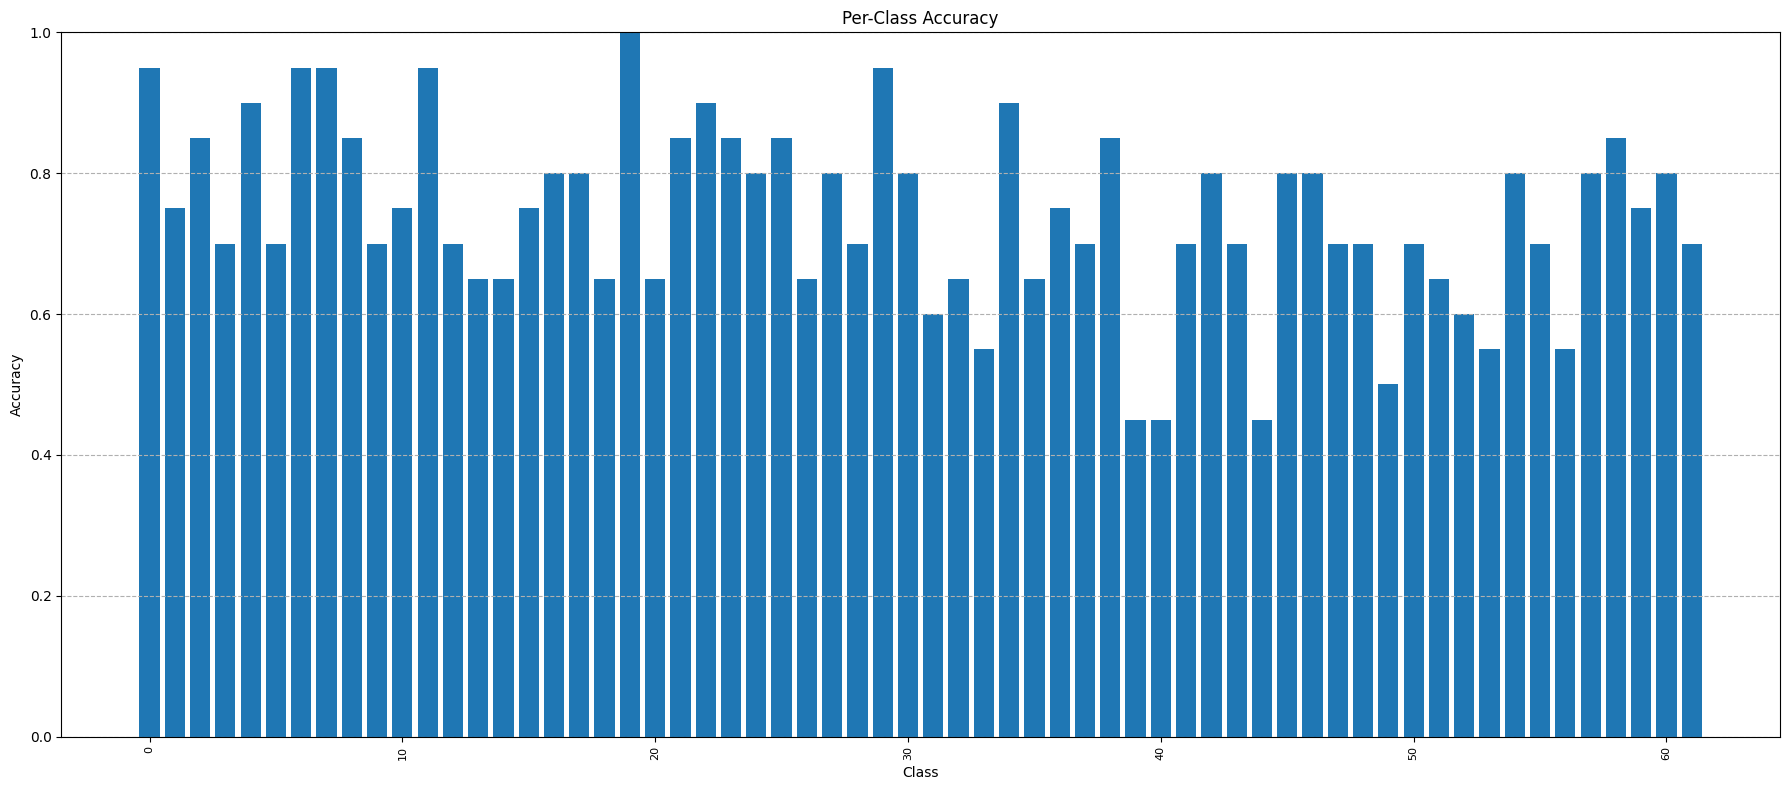

In [ ]:
# Per-Class Accuracy Bar Chart
class_accuracies = []
for i in range(len(class_names)):
    class_mask = (y_test == i)
    correct_predictions_in_class = np.sum((y_pred[class_mask] == y_test[class_mask]))
    total_in_class = np.sum(class_mask)
    if total_in_class > 0:
        class_accuracies.append(correct_predictions_in_class / total_in_class)
    else:
        class_accuracies.append(0) # No samples for this class in test set

plt.figure(figsize=(18, 8))
plt.bar(class_names, class_accuracies)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.xticks(rotation=90, fontsize=8)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
if 'model' in locals() and hasattr(model, 'predict'):
    y_pred_proba = model.predict(x_test)
else:
    print("Warning: 'model' object not found or does not have 'predict' method. Generating dummy probabilities.")
    # Fallback: create dummy probabilities if model is not available
    num_classes = len(class_names)
    num_samples = len(y_test)
    y_pred_proba = np.zeros((num_samples, num_classes))
    for i in range(num_samples):
        y_pred_proba[i, y_pred[i]] = 1.0 # Assign 100% to predicted class
        # Add some noise to make it look like probabilities
        noise = np.random.rand(num_classes) * 0.1
        y_pred_proba[i] = y_pred_proba[i] + noise
        y_pred_proba[i] = y_pred_proba[i] / np.sum(y_pred_proba[i])

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step



 Confusion Matrix (Raw Counts) ---


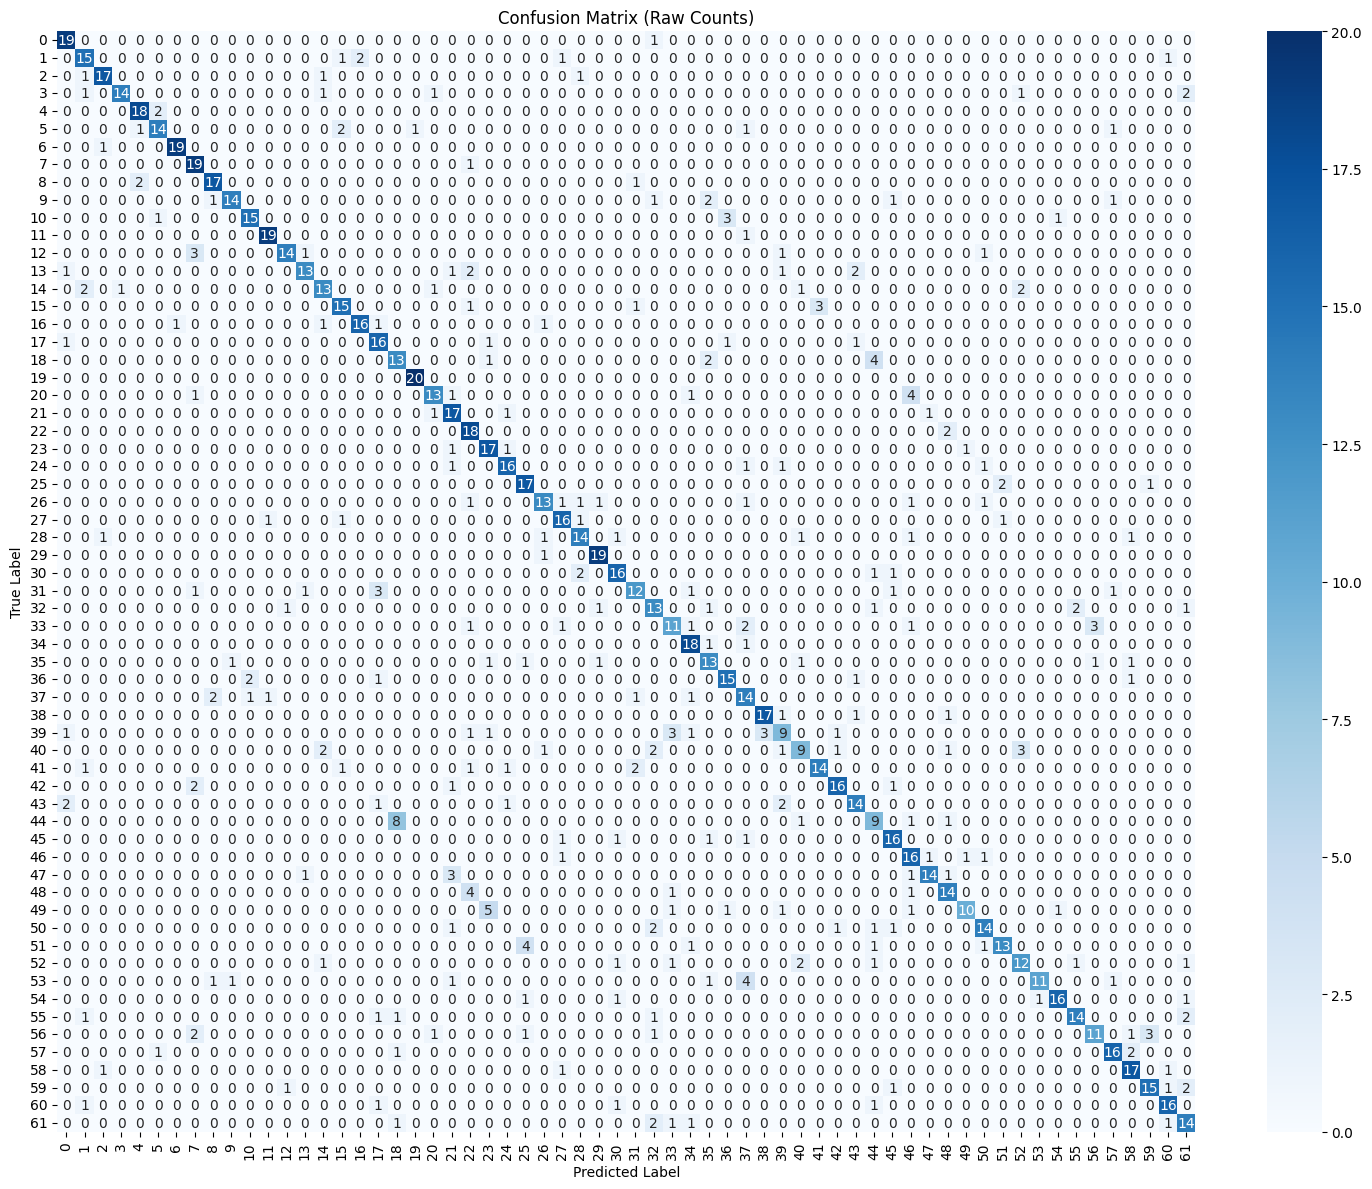

In [ ]:
# Confusion Matrix (Raw Counts)
print("\n Confusion Matrix (Raw Counts) ---")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Raw Counts)')
plt.tight_layout()
plt.show()


 Normalized Confusion Matrix (Proportions) ---


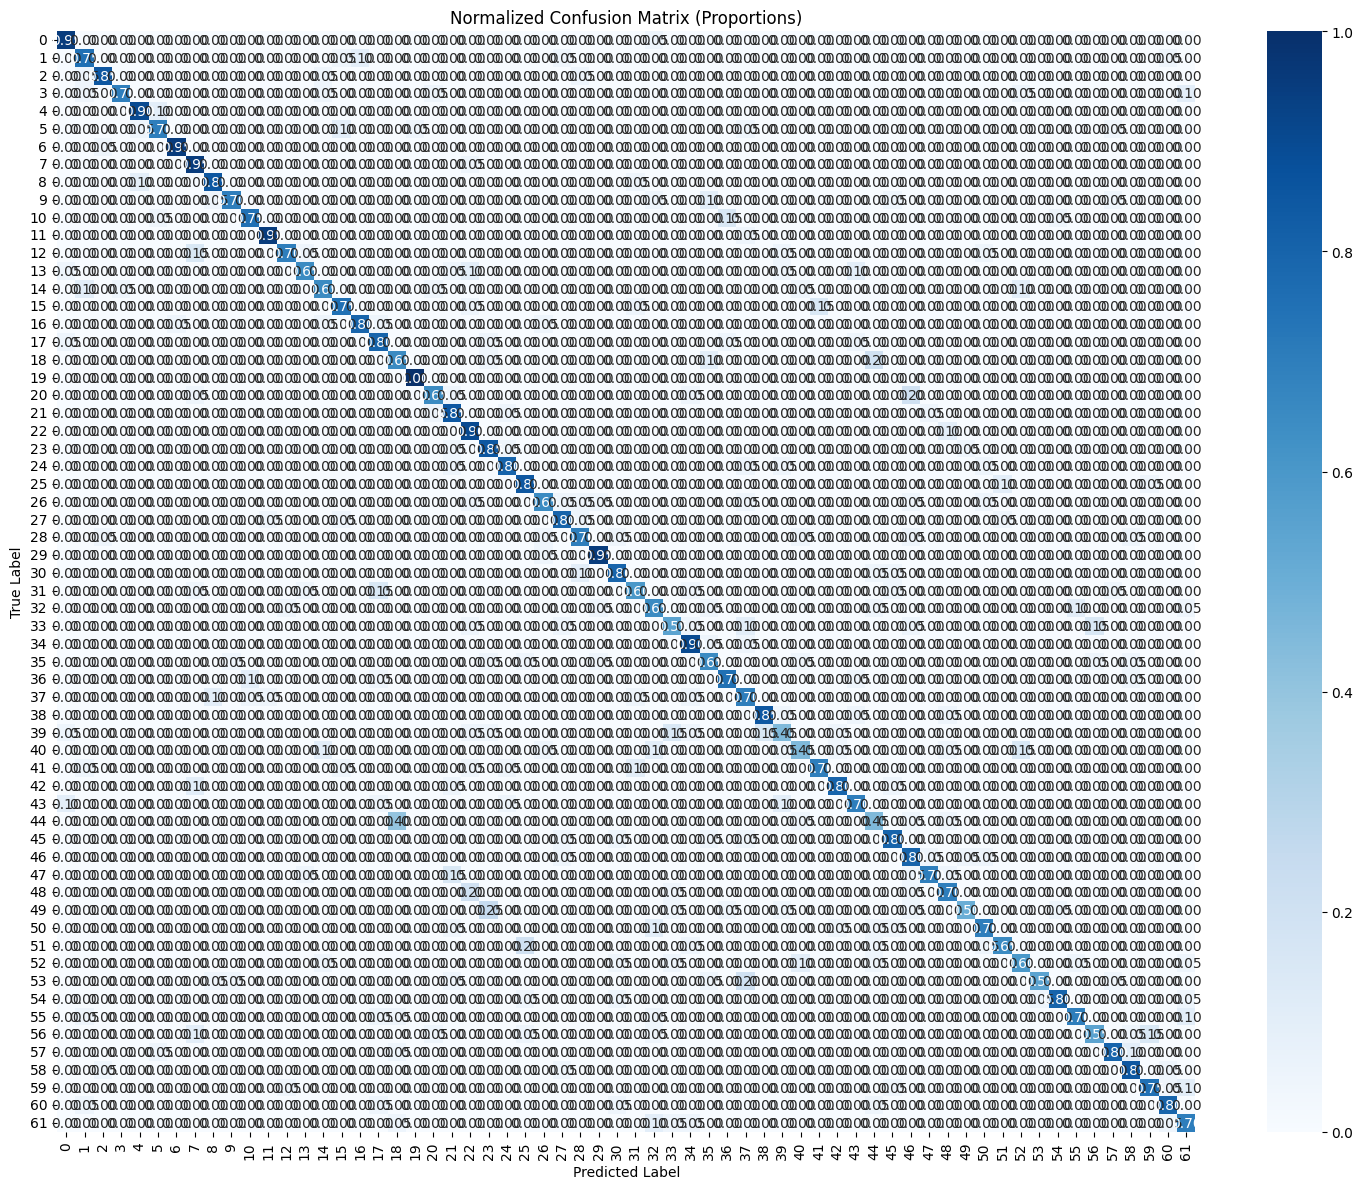

In [ ]:
#  Normalized Confusion Matrix (Proportions)
print("\n Normalized Confusion Matrix (Proportions) ---")
# Handle potential division by zero if a class has no true samples
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_normalized[np.isnan(cm_normalized)] = 0 # Replace NaN with 0 for classes with no true samples

plt.figure(figsize=(15, 12))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix (Proportions)')
plt.tight_layout()
plt.show()


 Classification Report Metrics ---


<Figure size 1800x800 with 0 Axes>

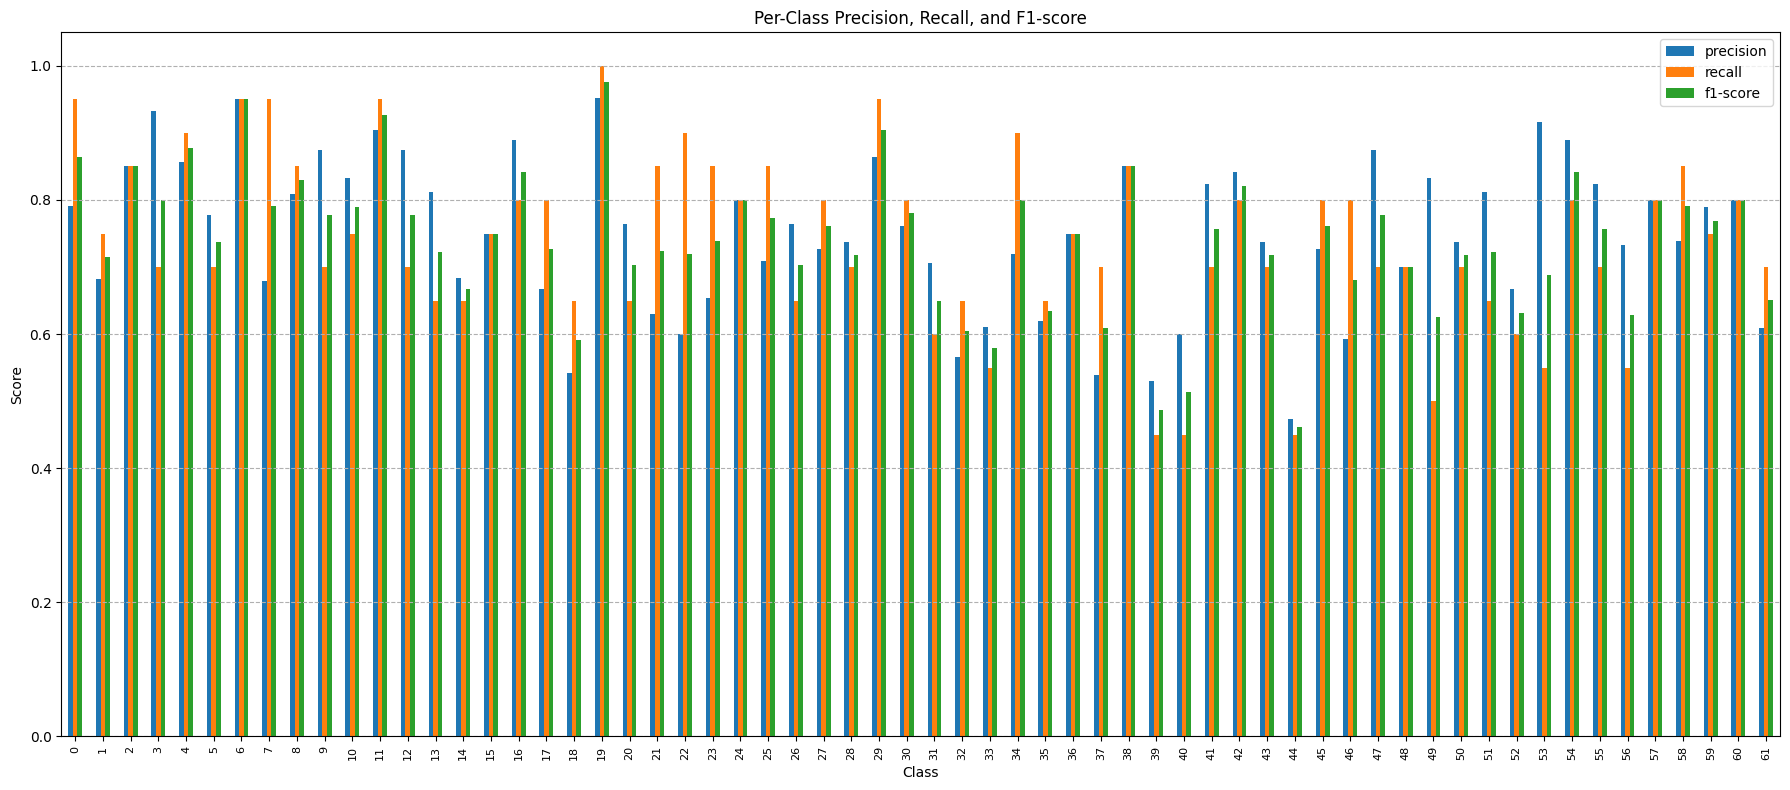

In [ ]:
#  Classification Report Metrics (Precision, Recall, F1-score) Bar Chart
print("\n Classification Report Metrics ---")
report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True, zero_division=0)
metrics_df = pd.DataFrame(report).transpose()
metrics_df = metrics_df.drop(columns=['support'])
metrics_df = metrics_df.drop(index=['accuracy', 'macro avg', 'weighted avg'], errors='ignore') # 'errors=ignore' handles cases where 'accuracy' might not be a direct index if no samples

plt.figure(figsize=(18, 8))
metrics_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(18, 8))
plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Per-Class Precision, Recall, and F1-score')
plt.xticks(rotation=90, fontsize=8)
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()


 Distribution of Maximum Prediction Probabilities ---


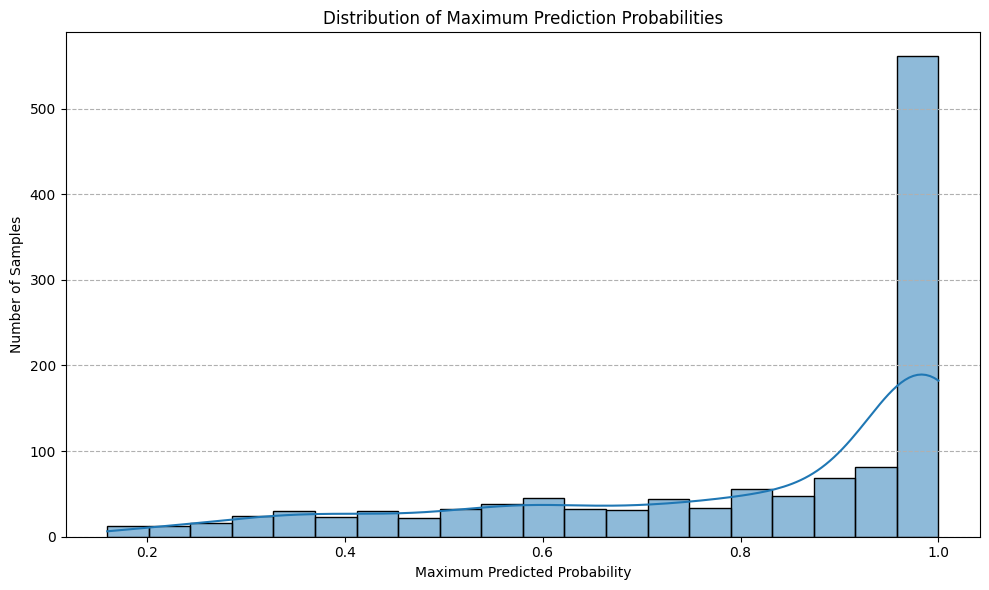

In [ ]:
# Distribution of Maximum Prediction Probabilities (Overall)
print("\n Distribution of Maximum Prediction Probabilities ---")
max_probs = np.max(y_pred_proba, axis=1)
plt.figure(figsize=(10, 6))
sns.histplot(max_probs, bins=20, kde=True)
plt.xlabel('Maximum Predicted Probability')
plt.ylabel('Number of Samples')
plt.title('Distribution of Maximum Prediction Probabilities')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()


 Distribution of Max Prediction Probabilities (Correct vs. Incorrect) ---


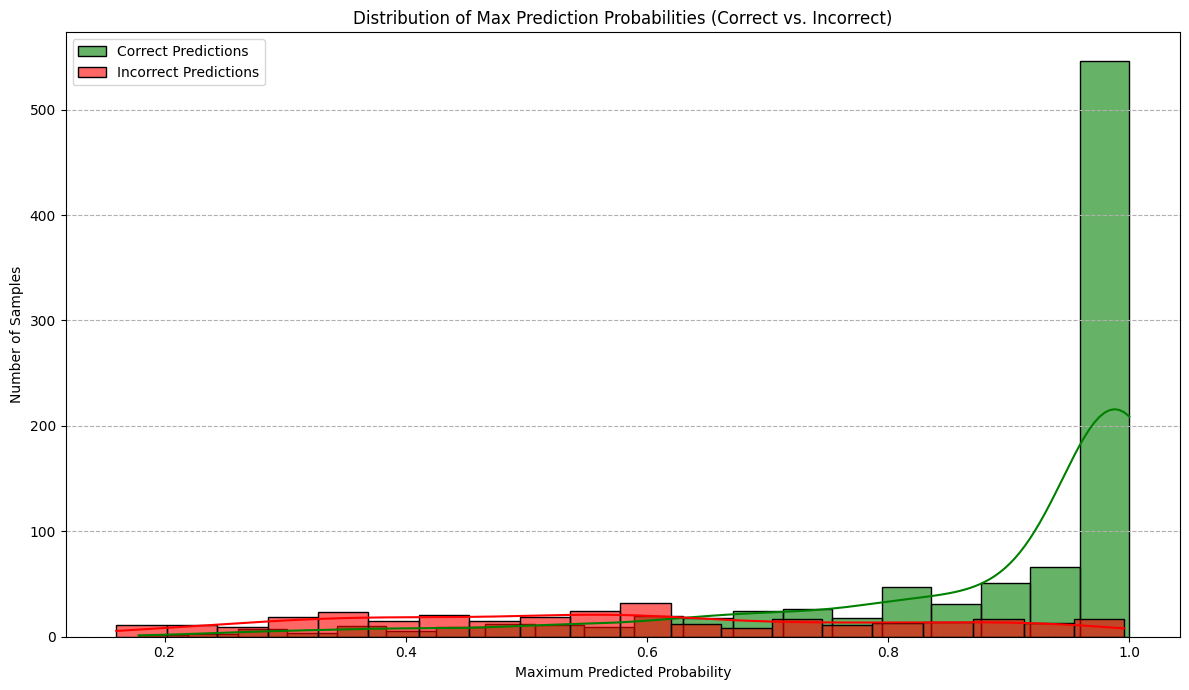

In [ ]:
# Distribution of Maximum Prediction Probabilities (Correct vs. Incorrect)
print("\n Distribution of Max Prediction Probabilities (Correct vs. Incorrect) ---")
correct_mask = (y_pred == y_test)
incorrect_mask = ~correct_mask

plt.figure(figsize=(12, 7))
sns.histplot(max_probs[correct_mask], bins=20, kde=True, color='green', label='Correct Predictions', alpha=0.6)
sns.histplot(max_probs[incorrect_mask], bins=20, kde=True, color='red', label='Incorrect Predictions', alpha=0.6)
plt.xlabel('Maximum Predicted Probability')
plt.ylabel('Number of Samples')
plt.title('Distribution of Max Prediction Probabilities (Correct vs. Incorrect)')
plt.legend()
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()


 Sample Images with Top 3 Predictions ---


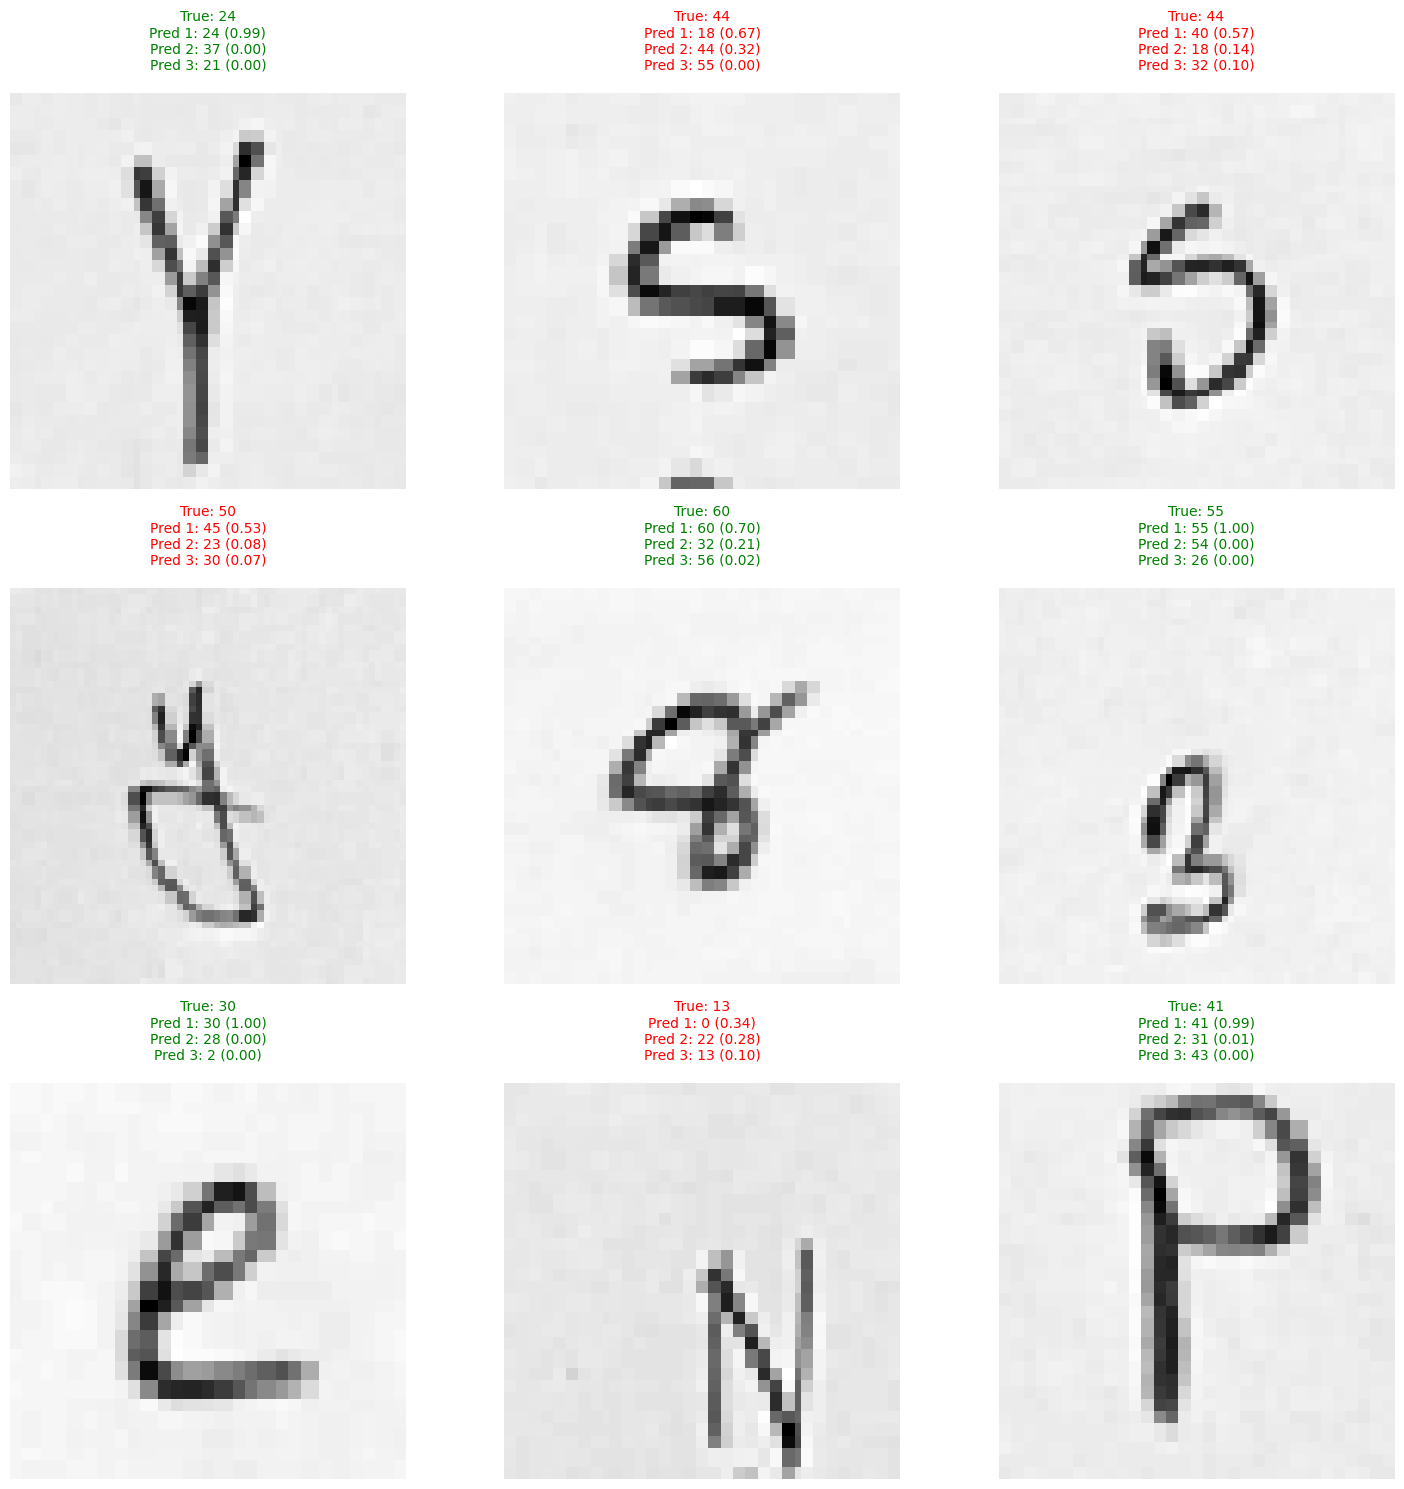

In [ ]:
# Sample Images with Top 3 Predicted Classes and Probabilities
print("\n Sample Images with Top 3 Predictions ---")
# Ensure there are enough samples to pick from
num_samples_to_display = min(9, len(x_test))
if num_samples_to_display > 0:
    sample_indices = np.random.choice(len(x_test), num_samples_to_display, replace=False)
    plt.figure(figsize=(15, 15))
    for i, idx in enumerate(sample_indices):
        plt.subplot(3, 3, i + 1)
        # Assuming x_test images are 64x64 grayscale (shape 64,64,1)
        plt.imshow(x_test[idx].reshape(64, 64), cmap='gray')
        true_label = class_names[y_test[idx]]
        
        # Get top 3 predictions
        top_3_indices = np.argsort(y_pred_proba[idx])[-3:][::-1]
        top_3_probs = y_pred_proba[idx][top_3_indices]
        
        title_str = f"True: {true_label}\n"
        for j in range(min(3, len(top_3_indices))): # Ensure we don't go out of bounds if less than 3 classes
            pred_label = class_names[top_3_indices[j]]
            prob = top_3_probs[j]
            title_str += f"Pred {j+1}: {pred_label} ({prob:.2f})\n"
        
        plt.title(title_str, color='green' if y_pred[idx] == y_test[idx] else 'red', fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("Not enough samples in x_test to display sample images.")



---  Class Distribution in Test Set ---


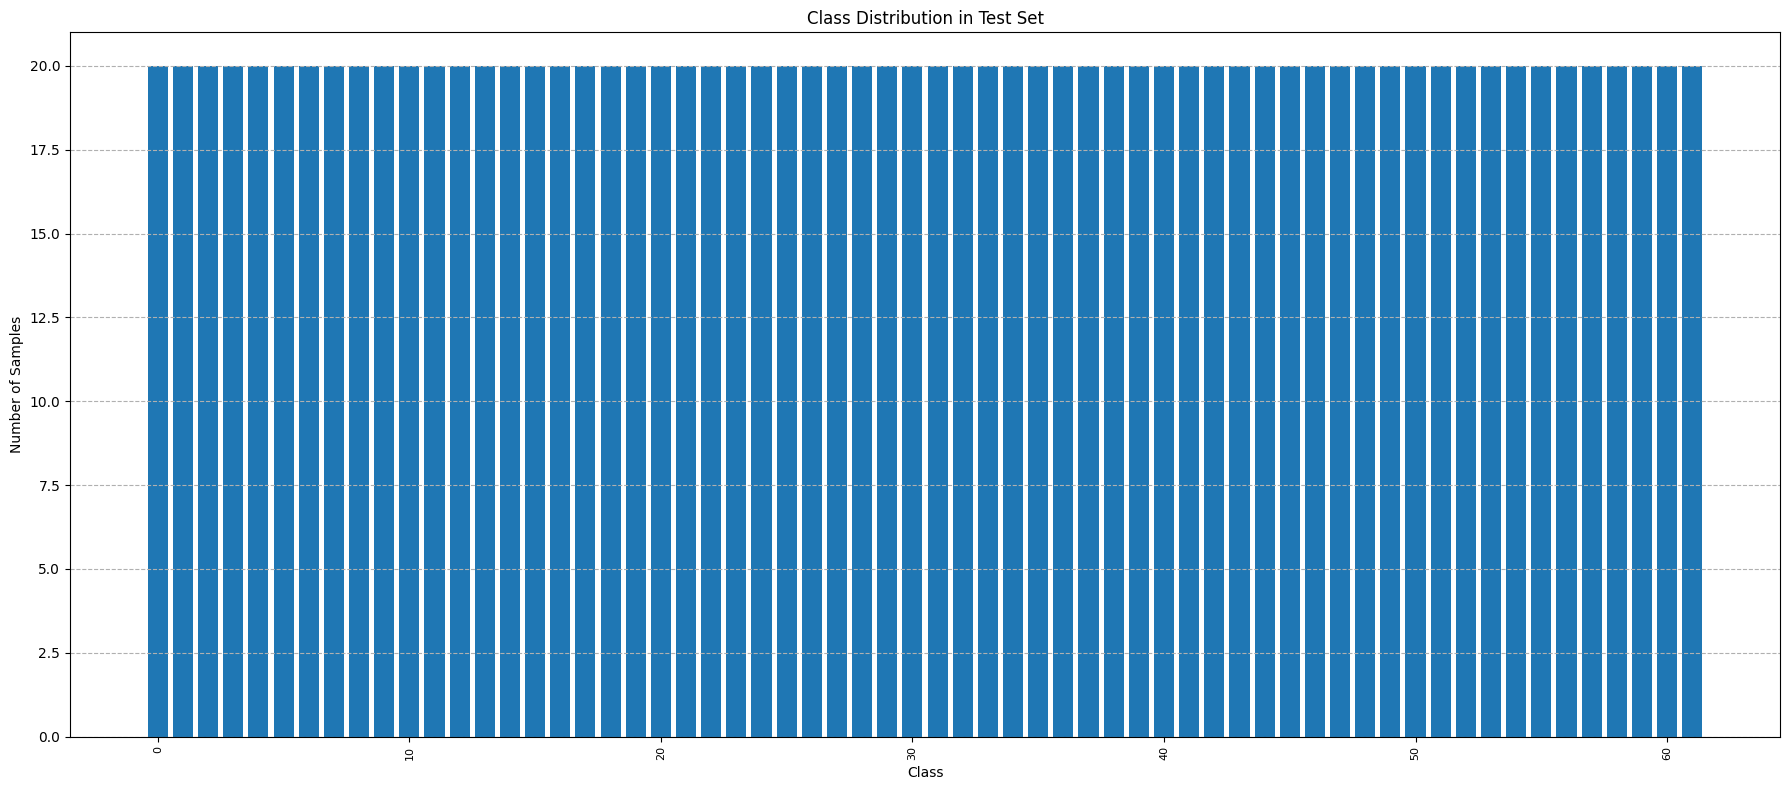

In [ ]:
# Class Distribution in Test Set
print("\n---  Class Distribution in Test Set ---")
unique_classes, class_counts = np.unique(y_test, return_counts=True)
# Create a full list of counts for all classes, filling 0 for missing ones
full_class_counts = np.zeros(len(class_names), dtype=int)
for i, count in zip(unique_classes, class_counts):
    full_class_counts[i] = count

plt.figure(figsize=(18, 8))
plt.bar(class_names, full_class_counts)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Test Set')
plt.xticks(rotation=90, fontsize=8)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()


 Top N Most Confused Class Pairs ---


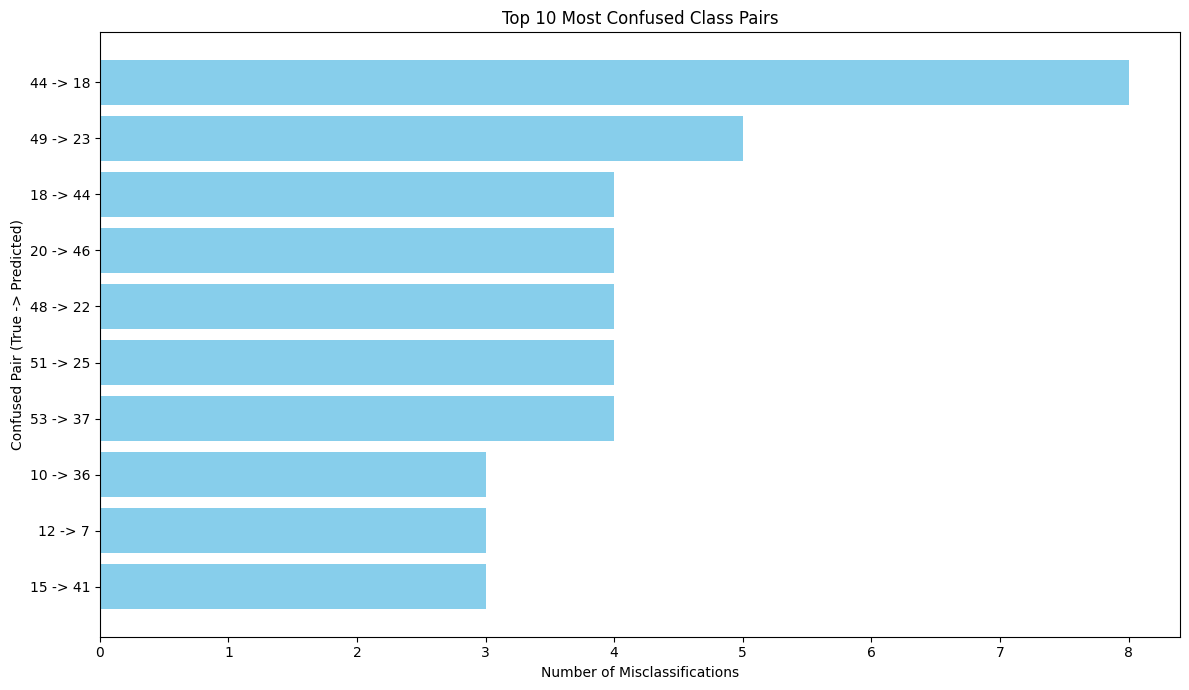

In [ ]:
# Top N Most Confused Class Pairs
print("\n Top N Most Confused Class Pairs ---")
# Create a matrix of misclassifications (off-diagonal elements of confusion matrix)
misclassification_matrix = cm - np.diag(np.diag(cm))
confused_pairs = []
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j and misclassification_matrix[i, j] > 0:
            confused_pairs.append(((class_names[i], class_names[j]), misclassification_matrix[i, j]))

confused_pairs.sort(key=lambda x: x[1], reverse=True)

num_top_pairs = min(10, len(confused_pairs)) # Display top 10 or fewer if less exist
if num_top_pairs > 0:
    labels = [f"{pair[0]} -> {pair[1]}" for pair, count in confused_pairs[:num_top_pairs]]
    counts = [count for pair, count in confused_pairs[:num_top_pairs]]

    plt.figure(figsize=(12, 7))
    plt.barh(labels[::-1], counts[::-1], color='skyblue') # Reverse for highest at top
    plt.xlabel('Number of Misclassifications')
    plt.ylabel('Confused Pair (True -> Predicted)')
    plt.title(f'Top {num_top_pairs} Most Confused Class Pairs')
    plt.tight_layout()
    plt.show()
else:
    print("No significant misclassifications found to analyze confused pairs.")



 Error Rate per Class (Sorted) ---


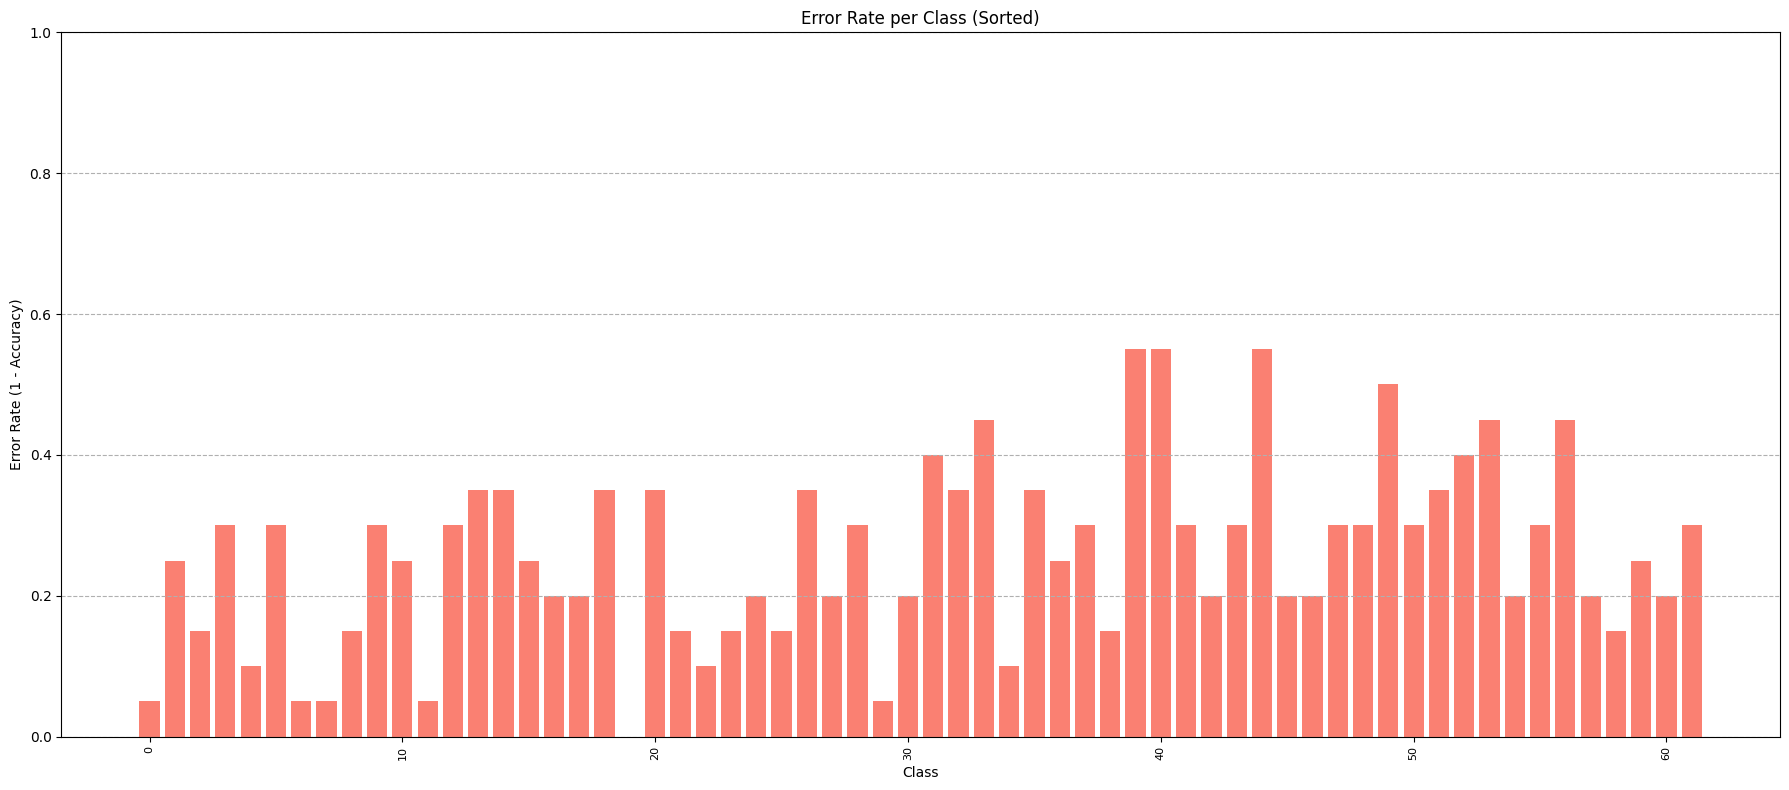

In [ ]:
# Error Rate per Class (Sorted)
print("\n Error Rate per Class (Sorted) ---")
class_errors = []
for i in range(len(class_names)):
    class_mask = (y_test == i)
    total_in_class = np.sum(class_mask)
    if total_in_class > 0:
        incorrect_predictions_in_class = np.sum((y_pred[class_mask] != y_test[class_mask]))
        class_errors.append((class_names[i], incorrect_predictions_in_class / total_in_class))
    else:
        class_errors.append((class_names[i], 0)) # No samples for this class

class_errors.sort(key=lambda x: x[1], reverse=True) # Sort by error rate descending

error_labels = [item[0] for item in class_errors]
error_rates = [item[1] for item in class_errors]

plt.figure(figsize=(18, 8))
plt.bar(error_labels, error_rates, color='salmon')
plt.xlabel('Class')
plt.ylabel('Error Rate (1 - Accuracy)')
plt.title('Error Rate per Class (Sorted)')
plt.xticks(rotation=90, fontsize=8)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()



 ROC Curve (One-vs-Rest) for Selected Classes ---


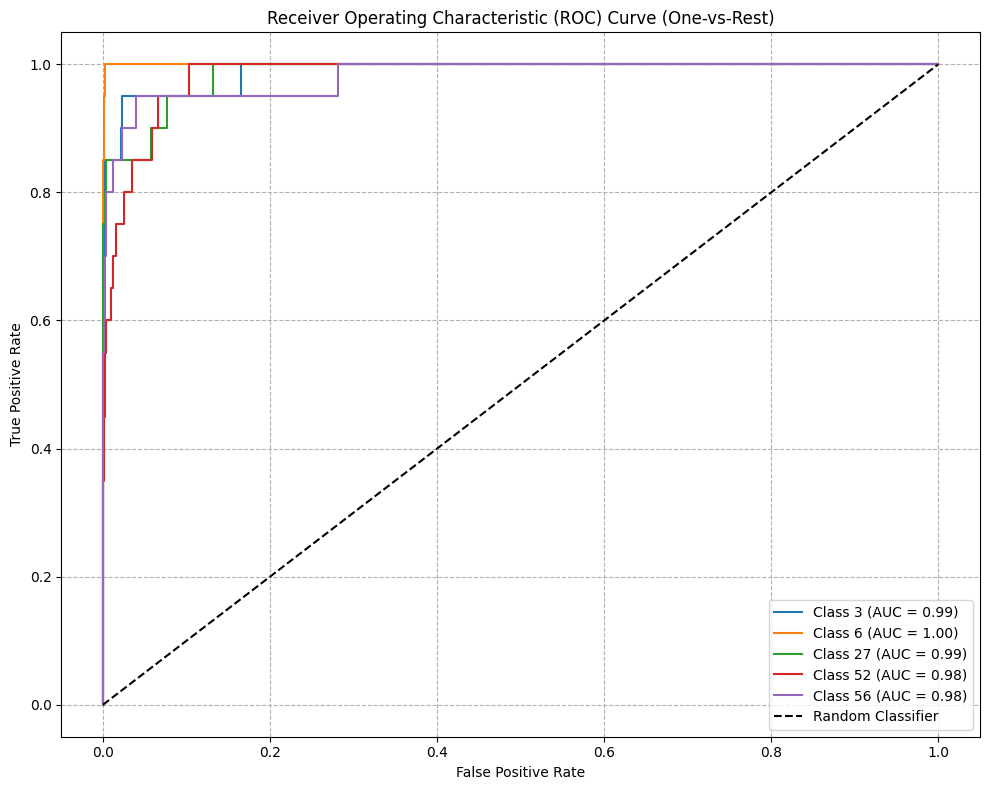

In [ ]:
# ROC Curve for a few representative classes (One-vs-Rest)
print("\n ROC Curve (One-vs-Rest) for Selected Classes ---")
# Binarize the true labels for ROC curve calculation
y_test_binarized = label_binarize(y_test, classes=range(len(class_names)))

# Select a few classes to plot ROC curves for (e.g., first 5, or some interesting ones)
num_classes_to_plot = min(5, len(class_names))
# Ensure selected classes actually have samples in the test set
available_classes = np.where(np.sum(y_test_binarized, axis=0) > 0)[0]
if len(available_classes) > 0:
    selected_classes_indices = np.random.choice(available_classes, min(num_classes_to_plot, len(available_classes)), replace=False)
    selected_classes_indices.sort() # For consistent plotting

    plt.figure(figsize=(10, 8))
    for i in selected_classes_indices:
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {class_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve (One-vs-Rest)')
    plt.legend(loc='lower right')
    plt.grid(linestyle='--')
    plt.tight_layout()
    plt.show()
else:
    print("No classes with samples in the test set to plot ROC curves.")
